# **Загрузка библиотек**

In [239]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nbformat
import plotly.graph_objects as go
import cmath 

from scipy.stats import normaltest, levene, norm
from scipy.optimize import curve_fit
from scipy.stats import f_oneway
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft, ifft


sns.set_theme()
sns.set_palette("deep")

# **Первая попытка**

## Оптимизированный код

In [ ]:
data_bpm = []
for i in range(1, 25):
    line_data = np.fromfile(f'data/data_bpm{i}.bin', dtype='short')
    data = line_data.reshape(-1, 4)
    df = pd.DataFrame(data, columns=['A', 'B', 'C', 'D'])
    data_bpm.append(df)
data_bpm[0]

In [241]:
period = 368
data = data_bpm[0].iloc[20*period:].reset_index().drop('index', axis=1)

In [242]:
data

A     B     C     D
0      -3377 -2785 -3730 -3637
1      -3447 -2586 -3584 -3665
2      -3471 -2543 -3449 -3714
3      -3501 -2664 -3494 -3493
4      -3571 -2631 -3652 -3498
...      ...   ...   ...   ...
242635 -1651 -2228 -2346 -2667
242636 -1789 -1987 -2276 -2519
242637 -2033 -1933 -2349 -2243
242638 -2215 -1868 -2448 -2181
242639 -2023 -1818 -2512 -2423

[242640 rows x 4 columns]

In [243]:
def plot(data: pd.DataFrame, period: int, number_of_periods: int, start_record_number: int=0, columns=None, **plot_params):
    columns = columns if columns else data.columns
    data[start_record_number: start_record_number + number_of_periods*period][columns].plot(**plot_params)
    for i in range(number_of_periods+1):
        plt.axvline(x=start_record_number+i*period, ls='--', color='gray')

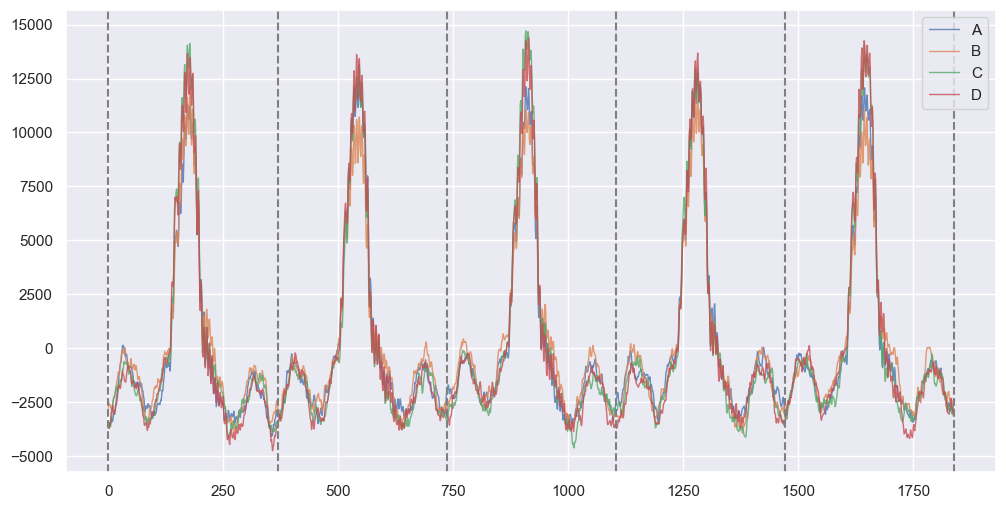

In [244]:
plot(data=data, period=period, start_record_number=0, number_of_periods=5, columns=[],
    lw=1, alpha=.8, figsize=(12, 6))

In [245]:
def periods_data(data: pd.Series, period: int):
    number_of_records = len(data)
    periods = data[:number_of_records // period * period].to_numpy().reshape(-1, period)
    periods_data = pd.DataFrame(periods.T)
    return periods_data

In [246]:
def periods_data_parameter(data: pd.Series, period: int, parameter: str, columns=[]):
    columns = columns if columns else data.columns
    result = pd.DataFrame()
    for column in columns:
        result[column] = periods_data(data[column], period).agg(parameter)
    return result

## Средние

<AxesSubplot:xlabel='Number of period', ylabel='Mean'>

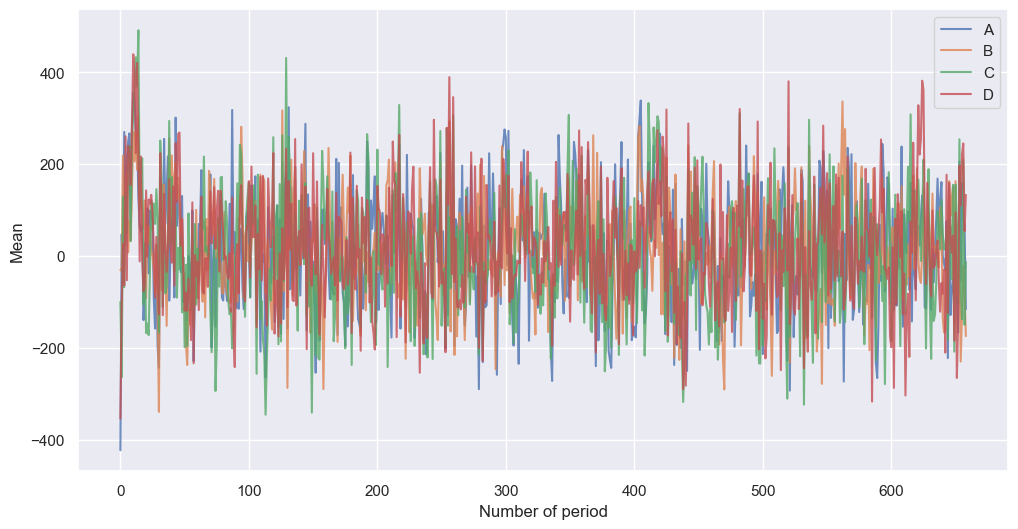

In [247]:
mean_data = periods_data_parameter(data, period, 'mean')
mean_data.plot(xlabel='Number of period', ylabel='Mean', alpha=.8, figsize=(12, 6))

In [248]:
f_oneway(mean_data['A'], mean_data['B'], mean_data['C'], mean_data['D'])

F_onewayResult(statistic=1.6097871856027783, pvalue=0.18500232290497012)

In [249]:
pd.DataFrame(mean_data.mean(), columns=['Mean'])

Mean
A   9.001765
B  11.046596
C   6.507381
D  20.735667

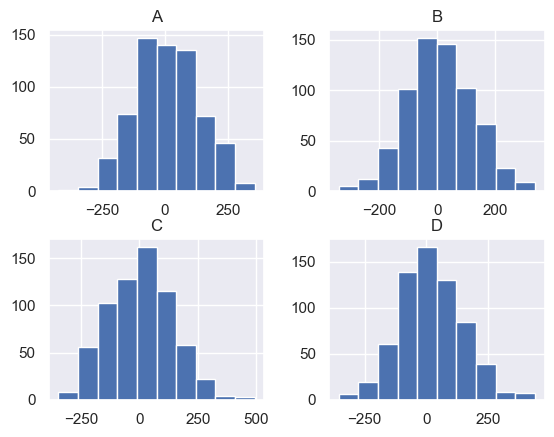

In [250]:
mean_data.hist();

In [251]:
pd.DataFrame(mean_data.mean(), columns = ['Mean of mean'])

Mean of mean
A      9.001765
B     11.046596
C      6.507381
D     20.735667

In [252]:
levene(*mean_data.to_numpy().T)

LeveneResult(statistic=8.867400015677692, pvalue=7.589655749870371e-06)

In [253]:
pd.DataFrame(mean_data.var(), columns = ['Variance of means'])

Variance of means
A       16233.679269
B       12427.469528
C       18513.976599
D       16279.328145

In [254]:
data_mean = periods_data_parameter(data, period, 'mean')

test_anova, p_anova = f_oneway(data_mean['A'], data_mean['B'], data_mean['C'], data_mean['D'])
test_leven, p_leven = levene(data_mean['A'], data_mean['B'], data_mean['C'], data_mean['D'])

print(f'Критериый о равенстве средних: \nStatistics = {test_anova}, p-value = {p_anova}\n')
print(f'Критериый о равенстве дисперсий: \nStatistics = {test_leven}, p-value = {p_leven}')

Критериый о равенстве средних: 
Statistics = 1.6097871856027783, p-value = 0.18500232290497012

Критериый о равенстве дисперсий: 
Statistics = 8.867400015677692, p-value = 7.589655749870371e-06


## Среднеквадратичные отклонения

<AxesSubplot:xlabel='Number of period', ylabel='Standart deviation'>

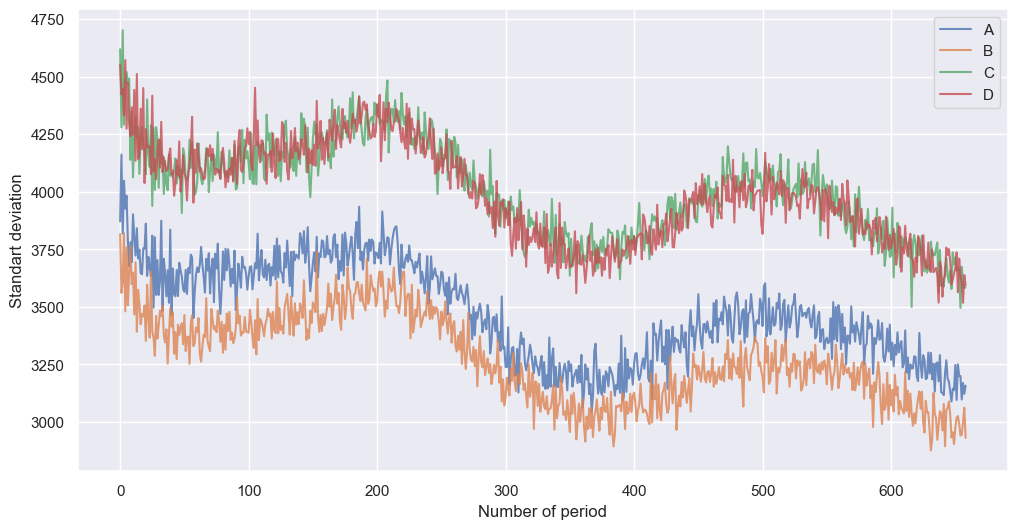

In [255]:
std_data = periods_data_parameter(data, period, 'std')
std_data.plot(xlabel='Number of period', ylabel='Standart deviation', alpha=.8, figsize=(12, 6))

In [256]:
f_oneway(*std_data.to_numpy().T)

F_onewayResult(statistic=2146.237918716715, pvalue=0.0)

In [257]:
levene(*std_data.to_numpy().T)

LeveneResult(statistic=4.1068339924078305, pvalue=0.00644072605719384)

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'C'}>,
        <AxesSubplot:title={'center':'D'}>]], dtype=object)

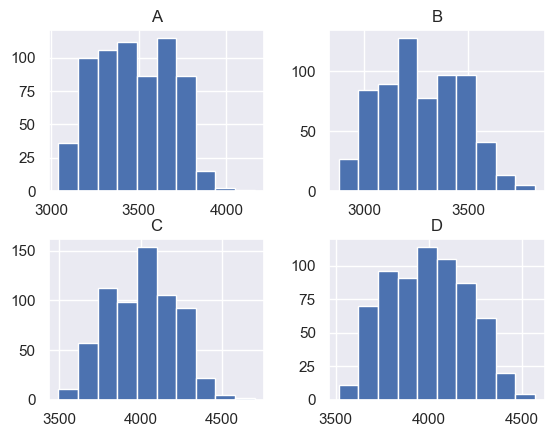

In [258]:
std_data.hist()

In [259]:
data_std = periods_data_parameter(data, period, 'std')

test_anova, p_anova = f_oneway(data_std['A'], data_std['B'], data_std['C'], data_std['D'])
test_leven, p_leven = levene(data_std['A'], data_std['B'], data_std['C'], data_std['D'])

print(f'Критериый о равенстве средних: \nStatistics = {test_anova}, p-value = {p_anova}\n')
print(f'Критериый о равенстве дисперсий: \nStatistics = {test_leven}, p-value = {p_leven}')

Критериый о равенстве средних: 
Statistics = 2146.237918716715, p-value = 0.0

Критериый о равенстве дисперсий: 
Statistics = 4.1068339924078305, p-value = 0.00644072605719384


## Максимумы

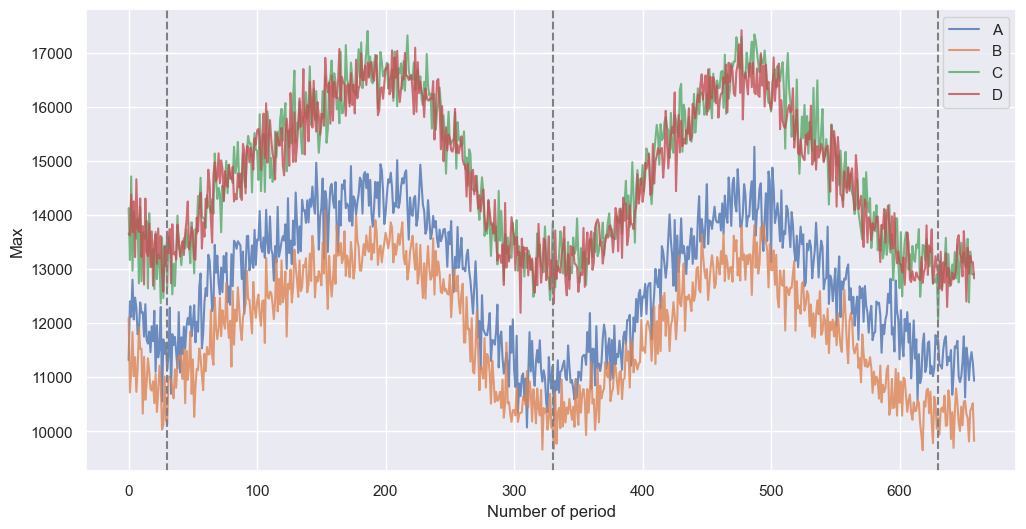

In [260]:
max_data = periods_data_parameter(data, period, 'max')
max_data.plot(xlabel='Number of period', ylabel='Max', alpha=.8, figsize=(12, 6))
plt.axvline(x=30, ls='--', color='gray')
plt.axvline(x=330, ls='--', color='gray')
plt.axvline(x=630, ls='--', color='gray')

In [261]:
f_oneway(*max_data.to_numpy().T)

F_onewayResult(statistic=927.2447376397844, pvalue=0.0)

In [262]:
levene(*max_data.to_numpy().T)

LeveneResult(statistic=18.439693411518586, pvalue=7.739939818468324e-12)

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'C'}>,
        <AxesSubplot:title={'center':'D'}>]], dtype=object)

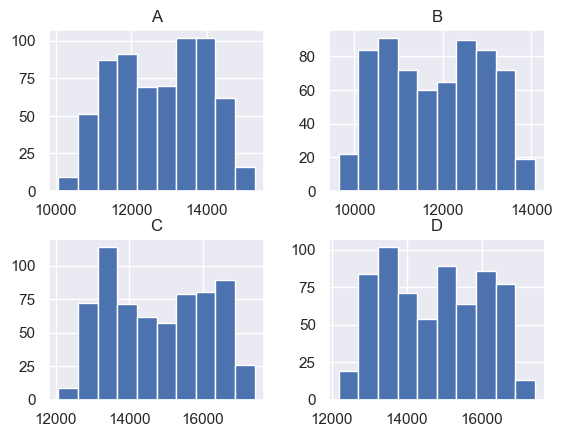

In [263]:
max_data.hist()

In [264]:
data_max = periods_data_parameter(data, period, 'max')

test_anova, p_anova = f_oneway(data_max['A'], data_max['B'], data_max['C'], data_max['D'])
test_leven, p_leven = levene(data_max['A'], data_max['B'], data_max['C'], data_max['D'])

print(f'Критериый о равенстве средних: \nStatistics = {test_anova}, p-value = {p_anova}\n')
print(f'Критериый о равенстве дисперсий: \nStatistics = {test_leven}, p-value = {p_leven}')

Критериый о равенстве средних: 
Statistics = 927.2447376397844, p-value = 0.0

Критериый о равенстве дисперсий: 
Statistics = 18.439693411518586, p-value = 7.739939818468324e-12


## Минимумы

<AxesSubplot:xlabel='Number of period', ylabel='Min'>

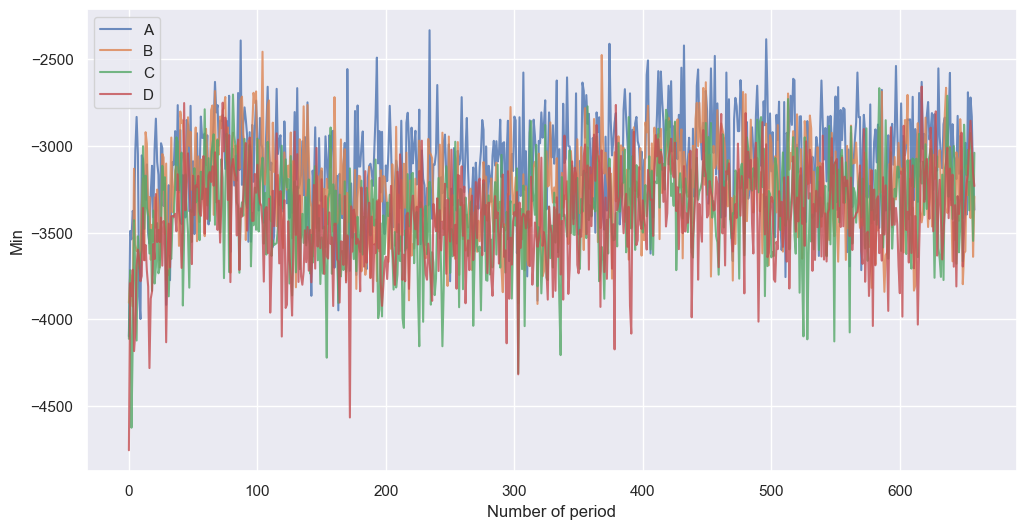

In [265]:
min_data = periods_data_parameter(data, period, 'min')
min_data.plot(xlabel='Number of period', ylabel='Min', alpha=.8, figsize=(12, 6))

In [266]:
f_oneway(*min_data.to_numpy().T)

F_onewayResult(statistic=193.44536486440276, pvalue=2.2972062266616695e-113)

In [267]:
levene(*min_data.to_numpy().T)

LeveneResult(statistic=0.08628145605491191, pvalue=0.967566796981439)

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'C'}>,
        <AxesSubplot:title={'center':'D'}>]], dtype=object)

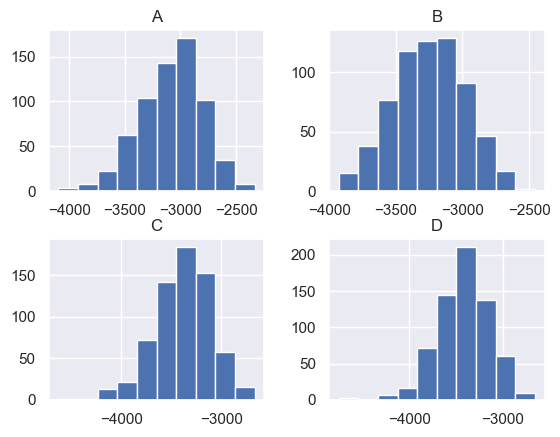

In [268]:
min_data.hist()

In [269]:
data_min = periods_data_parameter(data, period, 'min')

test_anova, p_anova = f_oneway(data_min['A'], data_min['B'], data_min['C'], data_min['D'])
test_leven, p_leven = levene(data_min['A'], data_min['B'], data_min['C'], data_min['D'])

print(f'Критериый о равенстве средних: \nStatistics = {test_anova}, p-value = {p_anova}\n')
print(f'Критериый о равенстве дисперсий: \nStatistics = {test_leven}, p-value = {p_leven}')

Критериый о равенстве средних: 
Statistics = 193.44536486440276, p-value = 2.2972062266616695e-113

Критериый о равенстве дисперсий: 
Statistics = 0.08628145605491191, p-value = 0.967566796981439


In [270]:
for i in min_data.columns:
    print(f'{i}: p-value = {normaltest(min_data[i]).pvalue}')

A: p-value = 0.0002114646565843152
B: p-value = 0.051744508951062036
C: p-value = 4.8301333964867485e-06
D: p-value = 1.5868037787062319e-06


## Распределения

In [271]:
z_data = periods_data(data['A'], period)

fig = go.Figure(data=[go.Surface(z=z_data.values)])

fig.update_layout(title='A period', autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [272]:
hist_data = z_data[0].loc[z_data[0] > 0]

<AxesSubplot:>

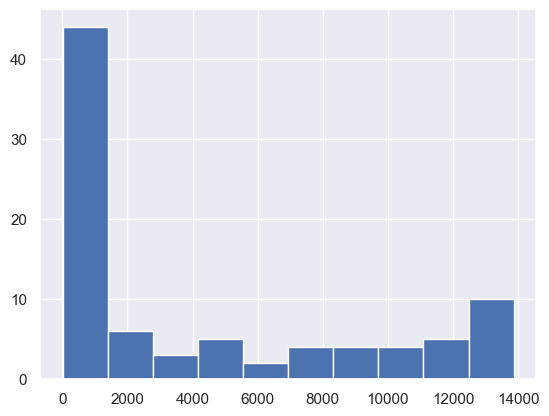

In [273]:
i = 535
hist_data = z_data[i].loc[z_data[i] > 0]
hist_data.hist()

## Координаты центра масс

<AxesSubplot:>

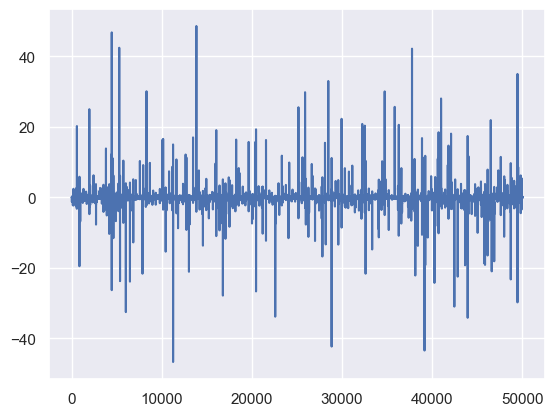

In [274]:
ac_data = ((data['A'] - data['C']) / (data['A'] + data['C']))
ac_data.loc[abs(ac_data)<50].iloc[:50_000].plot()

<AxesSubplot:>

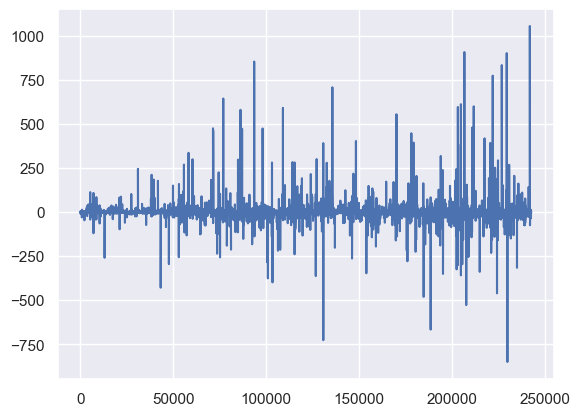

In [275]:
bd_data = ((data['B'] - data['D']) / (data['B'] + data['D']))
bd_data.plot()

In [276]:
bd_data[:1000].mean()

-0.19720537307755576

In [277]:
bd_data.to_numpy().shape

(242640,)

## Применение Фурье анализа

### Scipy

In [278]:
SAMPLE_RATE = 250 * 10^6
DURATION = period

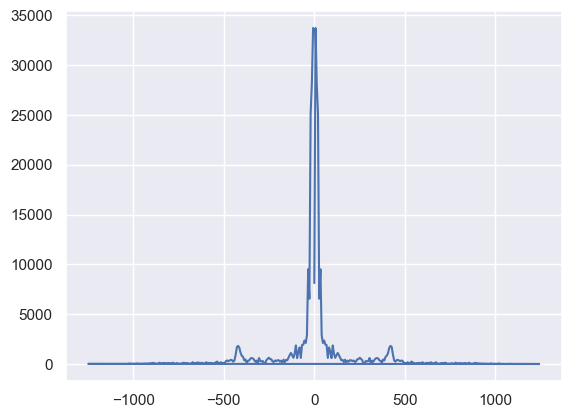

In [279]:
N = 368 # SAMPLE_RATE * DURATION
T = 1 / SAMPLE_RATE

signal = periods_data(data['A'], period)[0]

yf = fft(signal, norm='ortho')
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

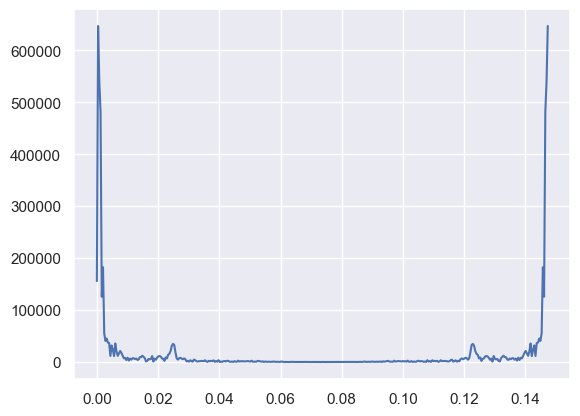

In [280]:
N = 368 # SAMPLE_RATE * DURATION
T = 1 / SAMPLE_RATE

x = np.linspace(0.0, N*T, N)
signal = periods_data(data['A'], period)[0]

# yf = fft(signal, norm='ortho')
yf = fft(signal)

xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(x, np.abs(yf))
plt.show()

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\histograms.py:839: ComplexWarning:

Casting complex values to real discards the imaginary part

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\transforms.py:775: ComplexWarning:

Casting complex values to real discards the imaginary part



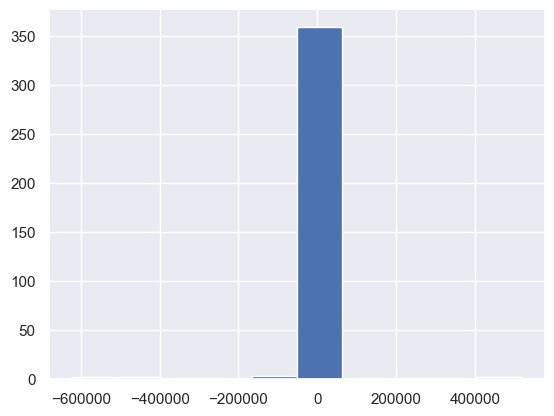

In [281]:
plt.hist(yf);

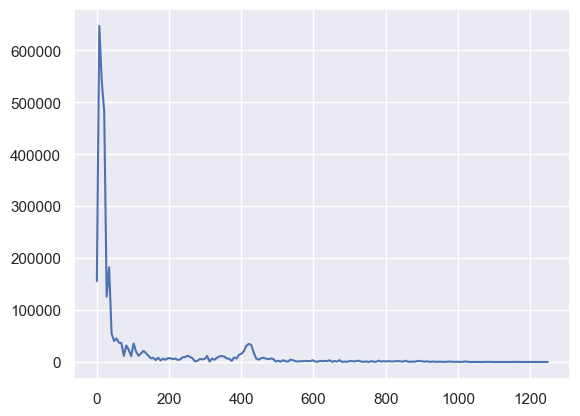

In [282]:
# обратите внимание на r в начале имён функций
yf = rfft(signal)
xf = rfftfreq(N, 1/SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

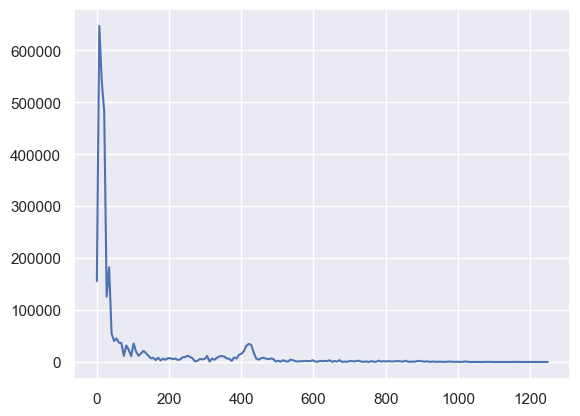

In [283]:
# Максимальная частота составляет половину частоты дискретизации
points_per_freq = len(xf) / (SAMPLE_RATE / 2)

# Наша целевая частота - 4000 Гц
target_idx = int(points_per_freq * 4000)
yf[target_idx-2:target_idx+2] = 0

plt.plot(xf, np.abs(yf))
plt.show()

### NumPy

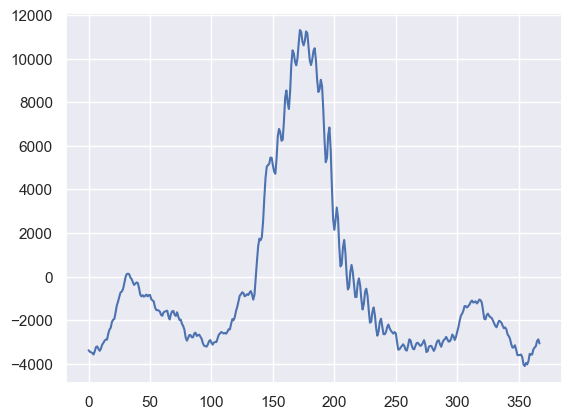

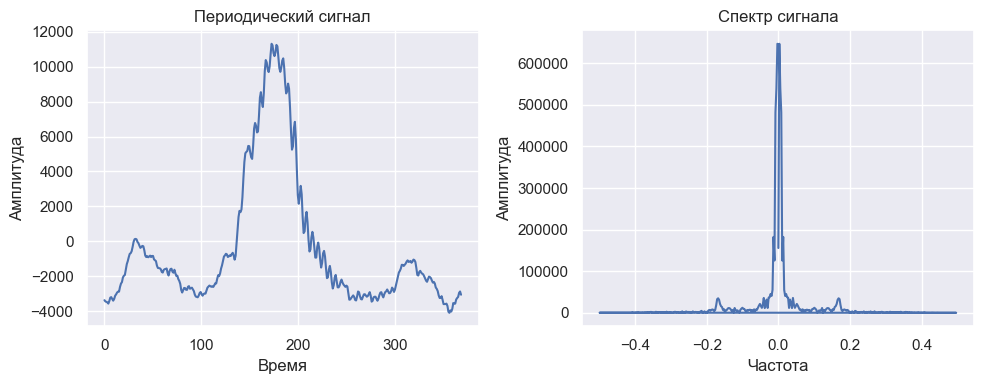

In [284]:
periods_data(data['A'], period)[0].plot()
t = np.linspace(0, 1, 368)
t = np.linspace(0, 368, 368) # Временные отсчеты

signal = periods_data(data['A'], period)[0] # Периодический сигнал

# Выполняем преобразование Фурье
fft_result = np.fft.fft(signal)

# Вычисляем частоты, соответствующие результатам преобразования Фурье
freqs = np.fft.fftfreq(len(signal), t[1] - t[0])

# Выводим результаты
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(t, signal)
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.title('Периодический сигнал')

plt.subplot(122)
plt.plot(freqs, np.abs(fft_result))
plt.xlabel('Частота')
plt.ylabel('Амплитуда')
plt.title('Спектр сигнала')

plt.tight_layout()
plt.show()


# **BPM data at Booster Injection with full and truncated injection**

## Data reading

In [908]:
N_compres = 10
N_FFT = 32 * 2048
N_fp = 20
delta_per = 0.005
N_fit = 5

In [909]:
skip = 8 * 6300 // 2
len_data = 4 * 1024**2
ofs = 220
delta_T = (250 * 10**6)**(-1)

In [286]:
data_bpm = []

line_data = np.fromfile(r'bpm_data\11_01_booster_libera08_hbpm3_1_full', dtype='int16')
data = line_data[skip:skip + len_data].reshape(-1, 4)
df = pd.DataFrame(data, columns=['A', 'B', 'C', 'D'])
data_bpm.append(df)

data_bpm[0]

A    B    C    D
0       -147 -273 -406   79
1       -157 -196 -416  321
2         17 -124 -416  383
3        373  -29 -415  230
4        247  -82 -421 -149
...      ...  ...  ...  ...
1048571  496  365   32  438
1048572  526  141  228  682
1048573  614  271  132  356
1048574  486  376  130  -11
1048575  134  134  139  138

[1048576 rows x 4 columns]

In [287]:
data_signal = data_bpm[0]

In [288]:
N = data_signal.shape[0]
N

1048576

In [289]:
sx = data_signal['A'] + data_signal['C']
delta_x = data_signal['A'] - data_signal['C']

sy = data_signal['B'] + data_signal['D']
delta_y = data_signal['B'] - data_signal['D']

In [916]:
def custom_fft(v):
    n = len(v)
    fft_result = fft(v)
    scale_factor = 1 / n
    
    return fft_result * scale_factor

In [945]:
def RevPer(S):
    S_short = np.zeros(N_FFT)
    
    for n in range(N_FFT):
        S_short[n] = 1 / N_compres * np.sum(S[n*N_compres:n*N_compres + N_compres])

    S_p = custom_fft(S_short)

    p = np.argmax(np.abs(S_p))

    L_apr = N_FFT / p * N_compres

    L_a = np.zeros(N_fp + 1)
    A = np.zeros(N_fp + 1, dtype='complex_')

    for n in range(N_fp+1): 
        L_a[n] = L_apr * (1 + delta_per * (2 * n - N_fp) / (N_fp))
        A[n] = 1 / (N_FFT * N_compres) * np.sum([S[k] * np.exp(2j * np.pi * k / L_a[n]) for k in range(N_FFT*N_compres)])

    p1 = np.argmax(np.abs(A))

    x = np.zeros(2* N_fit + 1)
    y = np.zeros(2* N_fit + 1)

    for n in range(2* N_fit + 1):
        x[n] = L_a[p1 - N_fit + n] - L_a[p1]
        y[n] = np.abs(A[p1 - N_fit + n])

    a = np.polyfit(x, y, 2)

    L_p = L_a[p1] - (a[1] / (2 * a[0]))

    return  L_p


In [946]:
period = RevPer(sx)

2128.7514970457146 2128.856103896104 -5.689634801304909 -27.195326023690495 11


In [895]:
j = np.arange(4 * period)

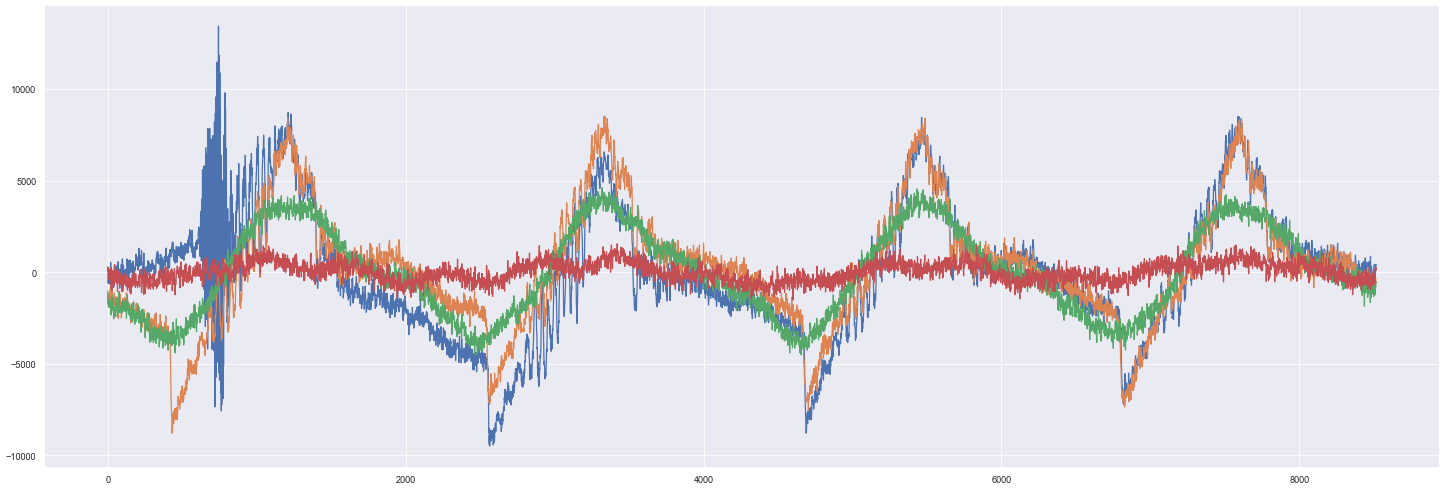

In [901]:
fig = plt.figure(figsize=(30, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(j, sx[j])
plt.plot(j, sx[j+np.floor(2*period)])
plt.plot(j, sx[j+np.floor(100*period)])
plt.plot(j, sx[j+np.floor(400*period)])

None

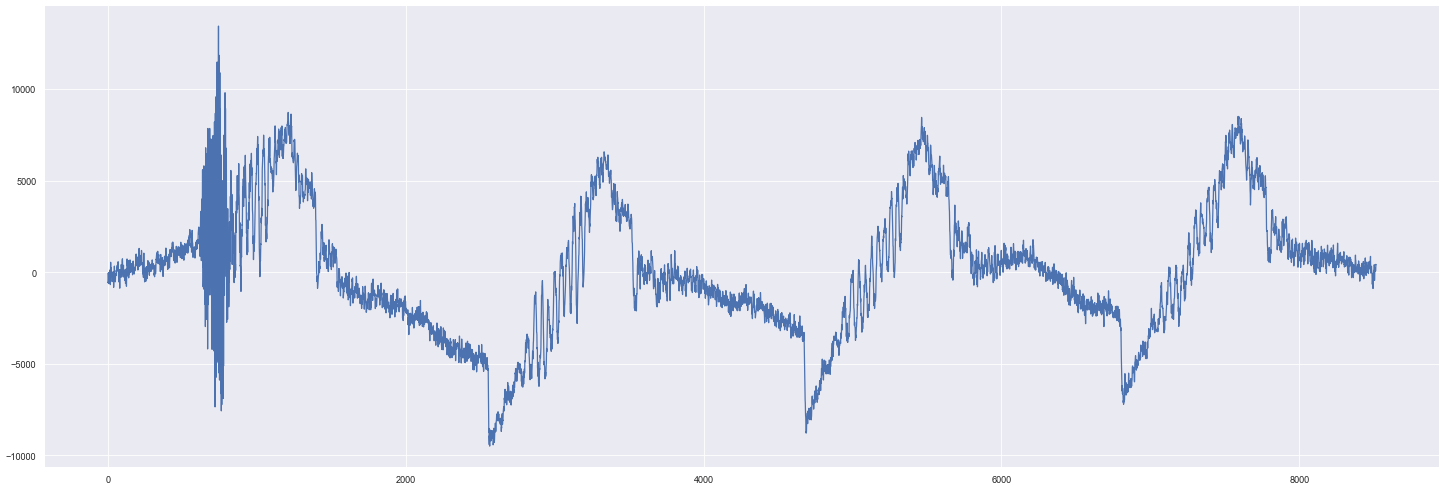

In [902]:
fig = plt.figure(figsize=(30, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(j, sx[j])

None

In [903]:
step = 10**6 * delta_T * j

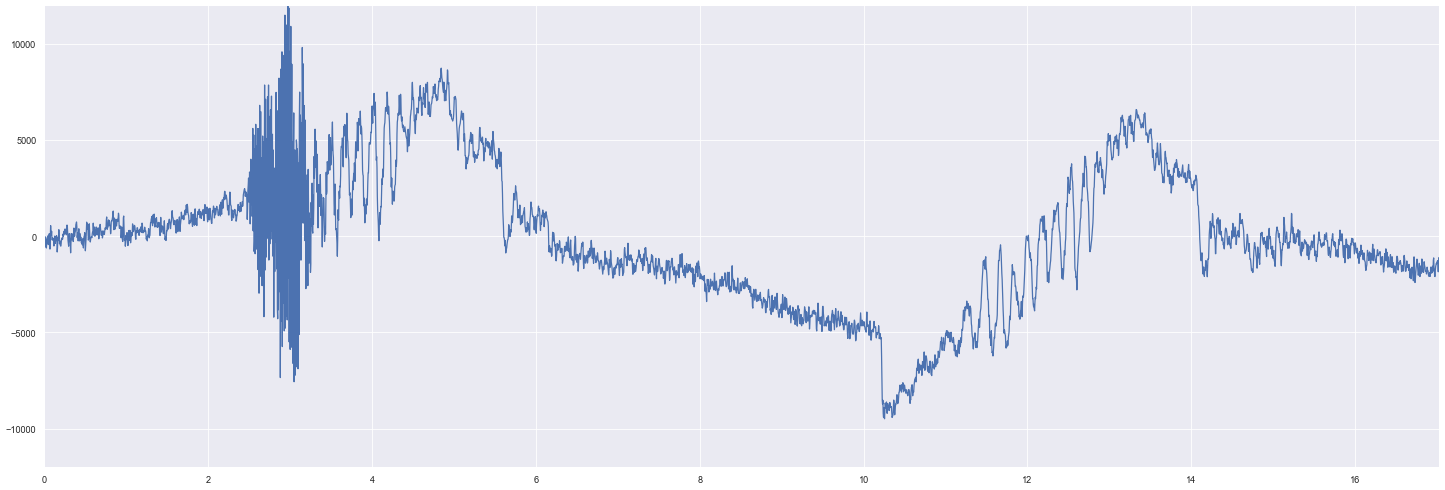

In [907]:
fig = plt.figure(figsize=(30, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(step, sx[j])

plt.xlim([0, 2 * period * delta_T * 10**6])
plt.ylim([-1.2 * 10**4, 1.2 * 10**4])

None

## Turn-by-turn beam bunch positions 

In [291]:
N_compres = 10
N_FFT = 32 * 2048
N_fp = 20
delta_per = 0.005
N_fit = 5
A_x = 64
A_y = 33

In [628]:
def get_mass_center_position(summary_resonace, difference_resonance, period_length): 
    
    number_of_periods = int(len(summary_resonace) / period_length) 
    mass_center_positions = np.zeros(number_of_periods) 
 
    for i in range(number_of_periods):

        if  int(i*period_length) == 1034572: # костыль для проверки
            summary_resonance_period_slice = np.array(summary_resonace, 'int64')[int(i*period_length)+1: int((i+1)*period_length)] 
            difference_resonance_period_slice = np.array(difference_resonance, 'int64')[int(i*period_length)+1: int((i+1)*period_length)]

        else: 
            
            summary_resonance_period_slice = np.array(summary_resonace, 'int64')[int(i*period_length): int((i+1)*period_length)] 
            difference_resonance_period_slice = np.array(difference_resonance, 'int64')[int(i*period_length): int((i+1)*period_length)]

        if summary_resonance_period_slice.shape[0] != int(period_length):   
            summary_resonance_period_slice = summary_resonance_period_slice[:int(period_length)]
            difference_resonance_period_slice = difference_resonance_period_slice[:int(period_length)]

        m_11 = float(np.sum(summary_resonance_period_slice**2))
        m_12 = float(np.sum(summary_resonance_period_slice)) 

        y_1 = float(summary_resonance_period_slice @ difference_resonance_period_slice) 
        y_2 = float(np.sum(difference_resonance_period_slice))
        
        mass_center_positions[i] = ((m_12 * y_2) - (np.floor(period_length) * y_1)) / (m_12 ** 2 - m_11 * np.floor(period_length)) 
 
    return mass_center_positions


In [629]:
x = A_x * get_mass_center_position(sx, delta_x, period)
y = A_y * get_mass_center_position(sy, delta_y, period)

In [875]:
N_tum = np.floor((N - np.max(ofs)) / period)

In [877]:
j = np.arange(N_tum)

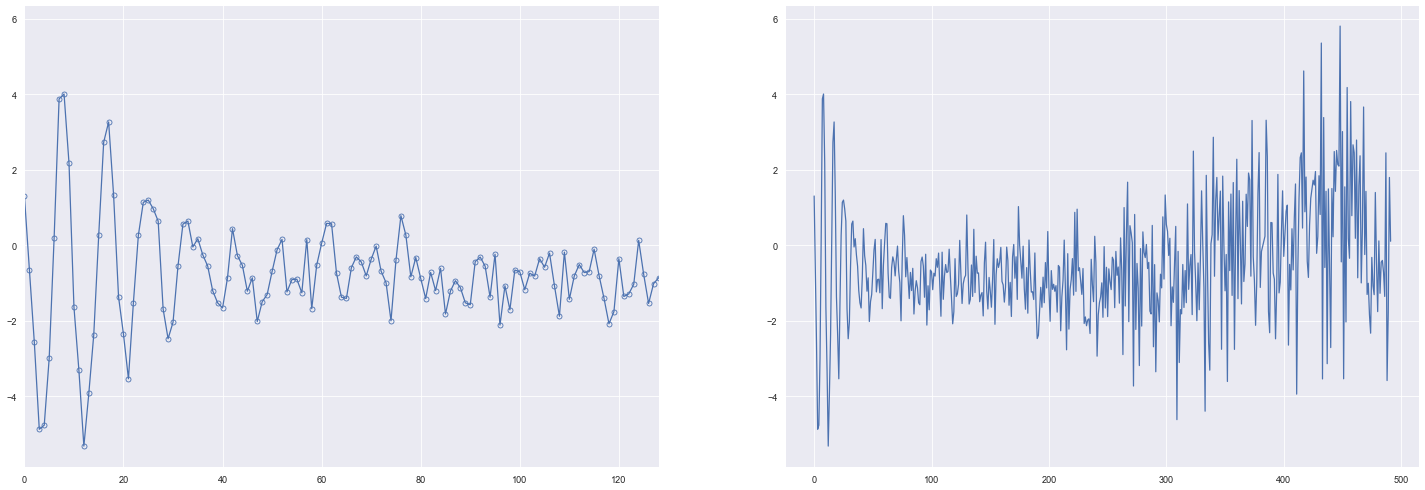

In [887]:
fig = plt.figure(figsize=(30, 10), dpi=60, facecolor="w", edgecolor="k")

plt.subplot(1,2,1)
plt.plot(j, x, marker='o', markerfacecolor='none')

plt.xlim([0, 128])

plt.subplot(1,2,2)
plt.plot(j, x)


None

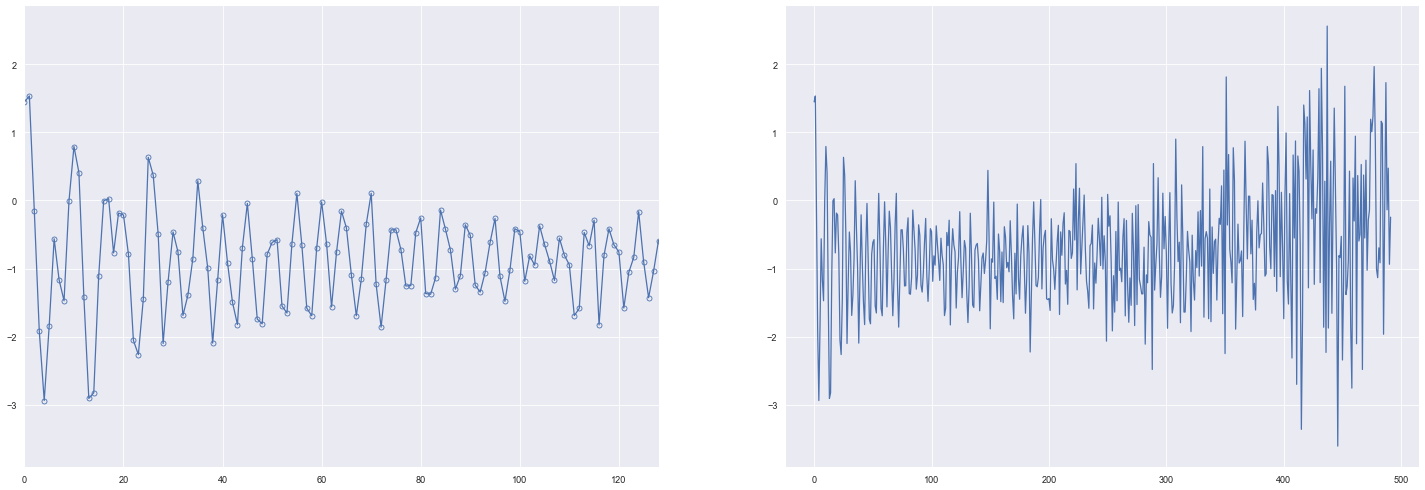

In [888]:
g = plt.figure(figsize=(30, 10), dpi=60, facecolor="w", edgecolor="k")

plt.subplot(1,2,1)
plt.plot(j, y, marker='o', markerfacecolor='none')

plt.xlim([0, 128])

plt.subplot(1,2,2)
plt.plot(j, y)


None

## Betatron tunes

In [301]:
def custom_fft(v):
    n = len(v)
    fft_result = fft(v)
    scale_factor = 1 / n
    
    return fft_result * scale_factor

In [302]:
NN = 256

jj = np.arange(NN)

xx = x[jj]
yy = y[jj]

S_x = custom_fft(xx)
S_y = custom_fft(yy)

jjj = np.arange(NN*0.5 + 1).astype('int')

S_xx = S_x[jjj]
S_yy = S_y[jjj]

k = np.arange(3)

S_xx[k] = 0
S_yy[k] = 0

p_x = np.argmax(np.abs(S_xx[:int(0.2*NN)]))
p_y = np.argmax(np.abs(S_yy[:int(0.5*NN)]))

v_x = p_x / NN
v_y = p_y / NN

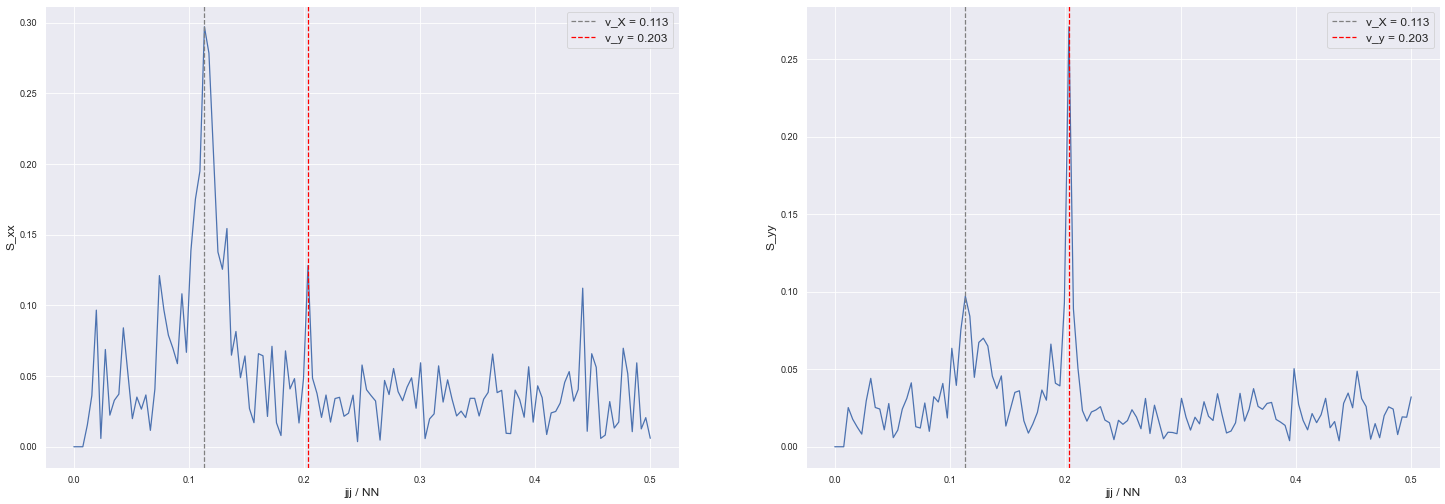

In [303]:
fig = plt.figure(figsize=(30, 10), dpi=60, facecolor="w", edgecolor="k")


plt.subplot(1,2,1)
plt.plot(jjj / NN, np.abs(S_xx))
plt.axvline(x=v_x, ls='--', color='gray', label=f'v_X = {np.round(v_x, 3)}')
plt.axvline(x=v_y, ls='--', color='red', label=f'v_y = {np.round(v_y, 3)}')
plt.xlabel('jjj / NN', fontsize='large')
plt.ylabel('S_xx', fontsize='large')
plt.legend(fontsize='large')

plt.subplot(1,2,2)
plt.plot(jjj/NN, np.abs(S_yy))
plt.axvline(x=v_x, ls='--', color='gray', label=f'v_X = {np.round(v_x, 3)}')
plt.axvline(x=v_y, ls='--', color='red', label=f'v_y = {np.round(v_y, 3)}')
plt.xlabel('jjj / NN', fontsize='large')
plt.ylabel('S_yy', fontsize='large')
plt.legend(fontsize='large')

None

In [651]:
N_p = 40
delta_Q = 0.02

In [745]:
def CorrectTune(x, Q_0, N_p, delta_Q):

    N_t = 256
    Q_p = np.zeros(N_p + 1)
    A_p = np.zeros(N_p + 1, dtype = "complex_")
    

    for i in range(N_p + 1):
        Q_p[i] = Q_0 + delta_Q * ((2 * i - N_p) / N_p)
        
        A_p[i] = np.sum([x[k] * np.exp(2j * np.pi * Q_p[i] * k) for k in range(N_t)])
    
    p = np.argmax(np.abs(A_p[:N_p+1]))

    p_1, p_2 = 0, 0

    for p1 in range(p+1, 0, -1):
        if np.abs(A_p[p1]) < 0.5 * np.abs(A_p[p]):
            p_1 = p1
            break

    for p2 in range(p, N_p):
        if np.abs(A_p[p2]) < 0.5 * np.abs(A_p[p]):
            p_2 = p2
            break
    
    csi = np.zeros(p_2+1)

    for n in range(p_1, p_2+1):
        csi[n] = n - 0.5 * (p_1 + p_2)

    M4 = np.sum(csi[p_1:p_2+1]**4)
    M2 = np.sum(csi[p_1:p_2+1]**2)
    Y2 = np.sum(csi[p_1:p_2+1]**2 @ np.abs(A_p[p_1:p_2+1]))
    Y1 = np.sum(csi[p_1:p_2+1] @ np.abs(A_p[p_1:p_2+1]))
    Y = np.sum(np.abs(A_p[p_1:p_2+1]))


    p_opt = (p_1 + p_2) / 2 - Y1 / (2 * M2) * (M2**2 - M4 * (p_2 - p_1 + 1)) / (M2 * Y - (p_2 - p_1 +1 ) * Y2)

    Q = Q_0 + delta_Q * (2 * p_opt - N_p) / N_p

    a = (M2 * Y - (p_2 - p_1 + 1) * Y2) / (M2**2 - M4 * (p_2 - p_1 + 1))

    b = Y1 / M2

    c = - (M4 * Y - M2 * Y2) / (M2**2 - M4 * (p_2 - p_1 + 1))

    r = [Q, p_1, p, p_2, p_opt, a, b, c, Q_p, A_p]

    return r 


In [747]:
res = CorrectTune(x, v_x, N_p, delta_Q)

In [749]:
res[0]

0.11415432916471673

## Tune chromaticity

In [306]:
vx = v_x - 0.01
vy = v_y - 0.03

In [307]:
find_theoretical_x = lambda n: 5 * np.cos(2 * np.pi * vx * n + 0.4) * np.exp(-(n**2) / (2 * 18**2)) 
find_theoretical_y = lambda n: 2 * np.cos(2 * np.pi * vy * (n - 40) + 0.) * np.exp(-(n**2) / (2 * 45**2))   

In [308]:
t = np.arange(70)

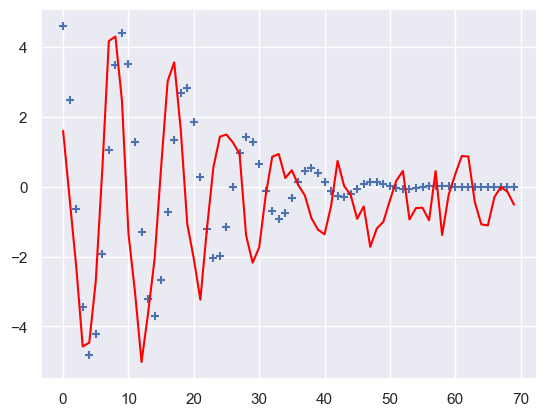

In [309]:
plt.scatter(t, find_theoretical_x(t), marker="+")
plt.plot(t, x[t] + .3, color='red');

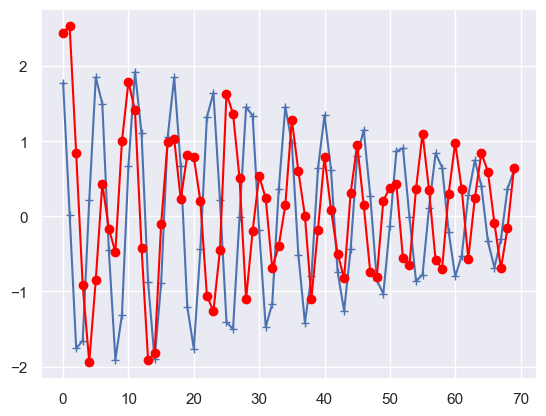

In [310]:
plt.plot(t, find_theoretical_y(t), marker="+")
plt.plot(t, y[t]+1, color='red', marker="o");

In [311]:
chi_x = 5.5
chi_y = 2.2
delta_p = 2.5 * 10**(-3)

In [312]:
find_AX = lambda n, chi: np.sin(2* np.pi * chi * delta_p * n) / (2 * np.pi * chi * n * delta_p)

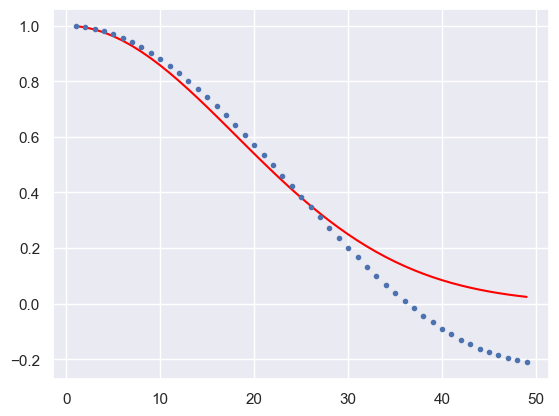

In [313]:
j = np.arange(1, 50)

plt.plot(j, np.exp(- j**2 / (2 * 18**2)), color='red')
plt.plot(j, find_AX(j, chi_x), marker=".", lw=0.01);

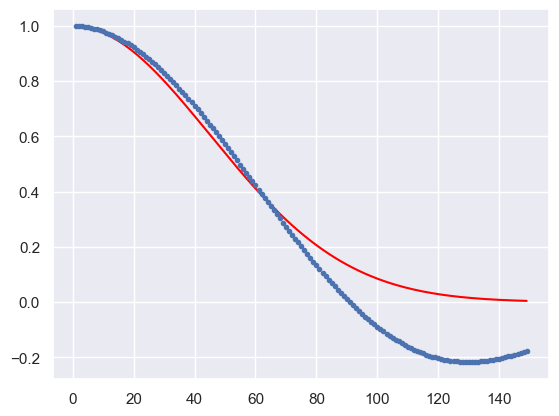

In [314]:
j = np.arange(1, 150)

plt.plot(j, np.exp(- j**2 / (2 * 45**2)), color='red')
plt.plot(j, find_AX(j, chi_y), marker=".", lw=0.01);

## Spectrum of the sum signal

In [315]:
ofs = 0
NNN = 128 * 1024

jj = np.arange(NNN)

s_1 = sx[jj+ofs] + sy[jj+ofs]
s_2 = sx[N+jj-NNN] + sy[N+jj-NNN] 

In [316]:
s_p1 = custom_fft(s_1)
s_p2 = custom_fft(s_2)

In [317]:
js = np.arange(NNN/2 + 1).astype('int')

t = js / (NNN * delta_T)

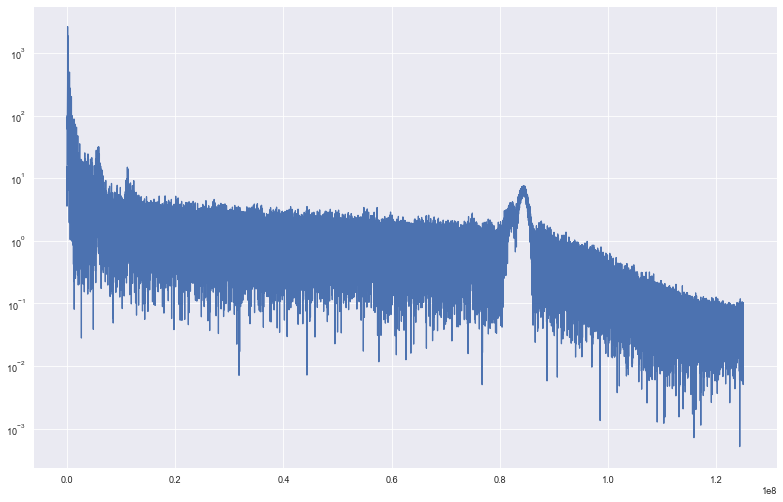

In [318]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(t, np.abs(s_p1[js]));
plt.yscale('log')

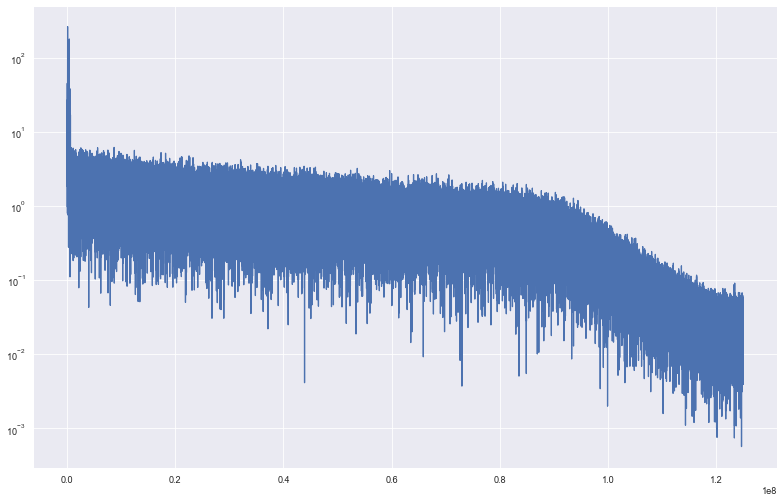

In [319]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(t, np.abs(s_p2[js]));
plt.yscale('log')

In [320]:
t = js / (NNN * delta_T) * 10**(-6)

In [591]:
f_0 = 1 / (delta_T * period)

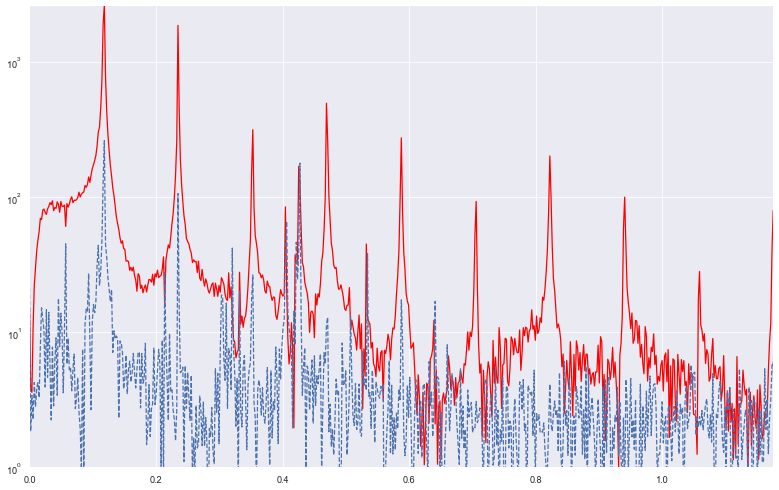

In [595]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(t, np.abs(s_p1[js]), color='red')
plt.plot(t, np.abs(s_p2[js]), ls='--')

plt.yscale('log')

plt.xlim([0, 10**(-6)* 10 * f_0])
plt.ylim([1, 2.633 * 10**3])

None

## Correction of frequency responce 

In [323]:
tau_f = 2.2 * 10 ** (-6)
p = 1
delta_f = 1 / (delta_T * 2128)

k = np.arange(1, int(2128 / 2 + 1))

f_k = delta_f * k

kk = np.arange(2128)

In [324]:
find_Kk = lambda x, p: ((2j * np.pi * f_k * tau_f) / (1 + 2j * np.pi * f_k * tau_f)) ** p

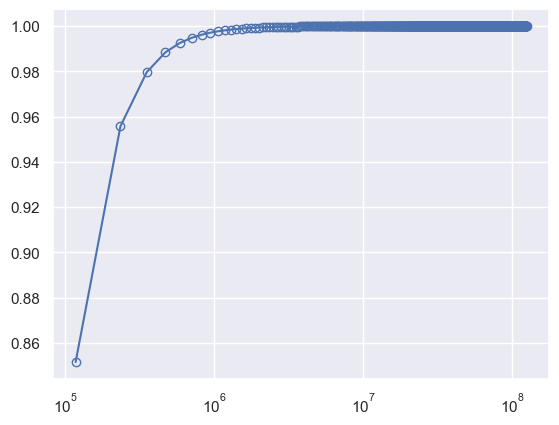

In [325]:
plt.plot(f_k, np.abs(find_Kk(f_k, p)), marker='o', markerfacecolor='none')
plt.xscale('log')

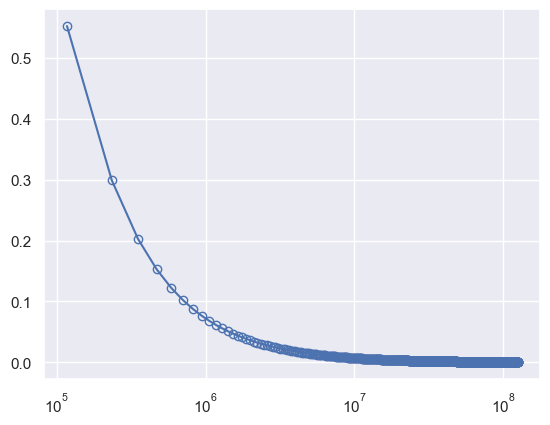

In [326]:
y = list(map(lambda x: cmath.phase(x), find_Kk(f_k, p)))

plt.plot(f_k, y, marker='o', markerfacecolor='none');
plt.xscale('log')

In [327]:
find_Kk(f_k, p).shape

(1064,)

**функции работают верно вплоть до значеней после запятой**

In [328]:
import math

In [362]:
def bunch_FFT(resonace, period):

    number_of_periods = int(len(resonace) / period) 
    resonance_period_slice_list = []
    per = []

    # теперь это работает идеально, все цифры совпадают
    for i in range(number_of_periods):
        if  int(i*period) == 1034572: # костыль для проверки
            resonance_period_slice = np.array(resonace, 'int64')[int(i*period)+1: int((i+1)*period)]
            # per.append(int(i*period))
        else:
            resonance_period_slice = np.array(resonace, 'int64')[int(i*period): int((i+1)*period)]
            # per.append(int(i*period))

        if resonance_period_slice.shape[0] != period:
            resonance_period_slice_list.append(resonance_period_slice[:int(period)])
        else:
            resonance_period_slice_list.append(resonance_period_slice)

    S = list(map(lambda x: fft(x) / x.shape[0], resonance_period_slice_list)) # возмжно стоит корректировать фурье # +
    Kk = find_Kk(f_k, p)

    for k in range(0, len(S)):

        S[k][1:1065] = S[k][1:1065] / Kk[:]
        S[k][:1063:-1] = S[k][:1063:-1] / Kk[:].conjugate()

    return S

In [363]:
def correct(resonace, period):
    S = bunch_FFT(resonace, period)

    number_of_periods = int(len(resonace) / period) 

    R = list(map(lambda x: (ifft(x) * x.shape[0]).real, S)) # верно 
 
    mn = []

    for k in range(number_of_periods):
        sum = []
        for n in range(int(period-60)):
            average_sum = 1 / 61 * np.sum(R[k][n:n+61])
            sum.append(average_sum)
        
        mn.append(sum)

    mn_min = list(map(lambda x: min(x), mn))

    for k in range(number_of_periods):
        R[k] = np.array([x - mn_min[k] for x in R[k]]) 

    return R

In [364]:
R = correct(sx, period)

In [366]:
I_b = lambda index: np.sum([x for x in R[index]]) 

In [367]:
Ib_list = []

for i in range(492):
    Ib_list.append(I_b(i))


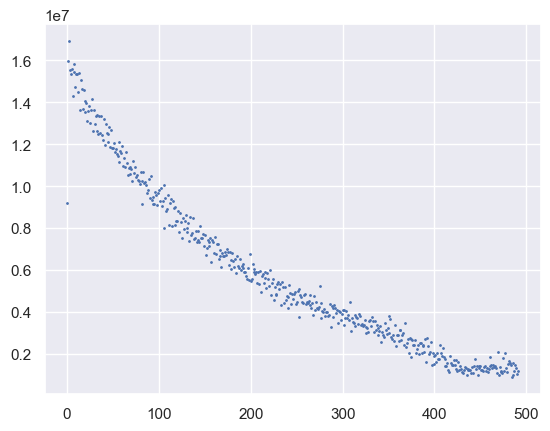

In [368]:
plt.scatter(np.arange(492), Ib_list, s=1)

In [369]:
R_0 = (R[0][kk] / 10 ** 3) + kk * 0.002 - 5
R_1 = (R[1][kk] / 10 ** 3) - kk * 0.0009
R_20 = (R[20][kk] / 10 ** 3) - (kk * 0.000 + 1)

step = 10**6 * delta_T * kk

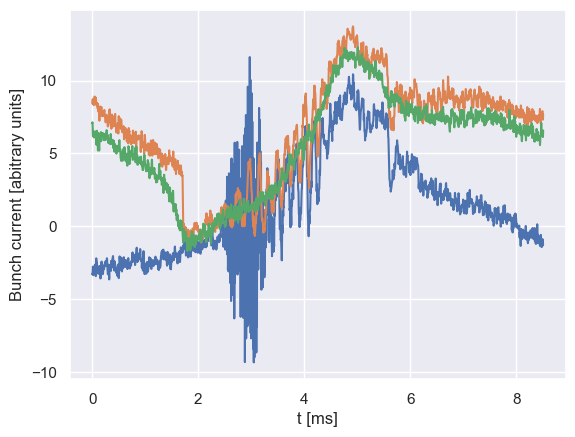

In [370]:
plt.plot(step, R_0)
plt.plot(step, R_1)
plt.plot(step, R_20)

plt.ylabel('Bunch current [abitrary units]')
plt.xlabel('t [ms]')
None

## Beam excitation by the kicke

**Тут все работает верно, осталось только верно построить графики**

In [371]:
S_sum = bunch_FFT(sx, period)

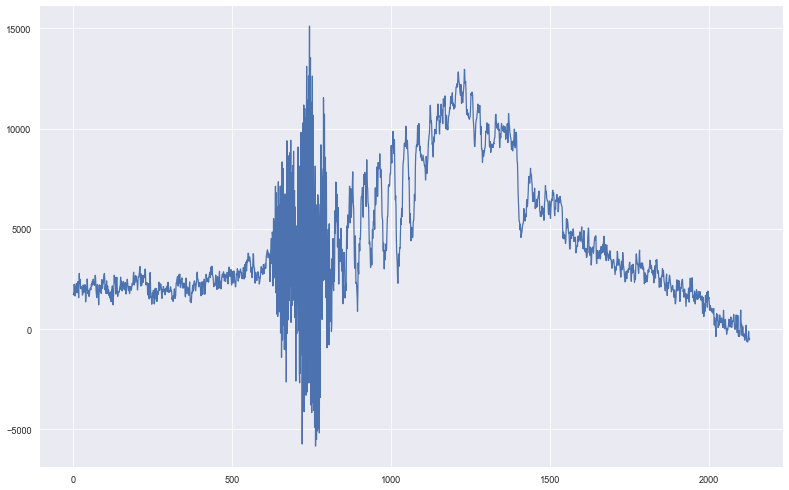

In [373]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(np.arange(len(R[0])), R[0]);

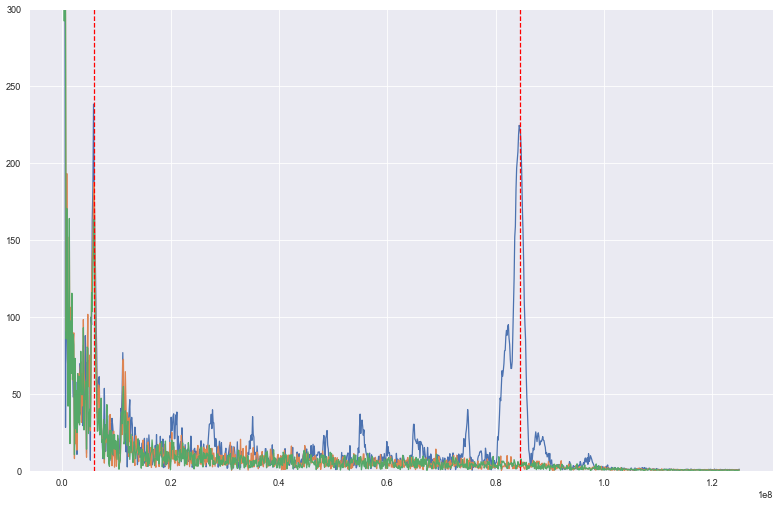

In [374]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(f_k, np.abs(S_sum[0][1:1065]))
plt.plot(f_k, np.abs(S_sum[1][1:1065]))
plt.plot(f_k, np.abs(S_sum[2][1:1065]))
plt.axvline(x=84.5*10**6, ls='--', color='red')
plt.axvline(x=5.8*10**6, ls='--', color='red')

plt.ylim([0, 300])

None

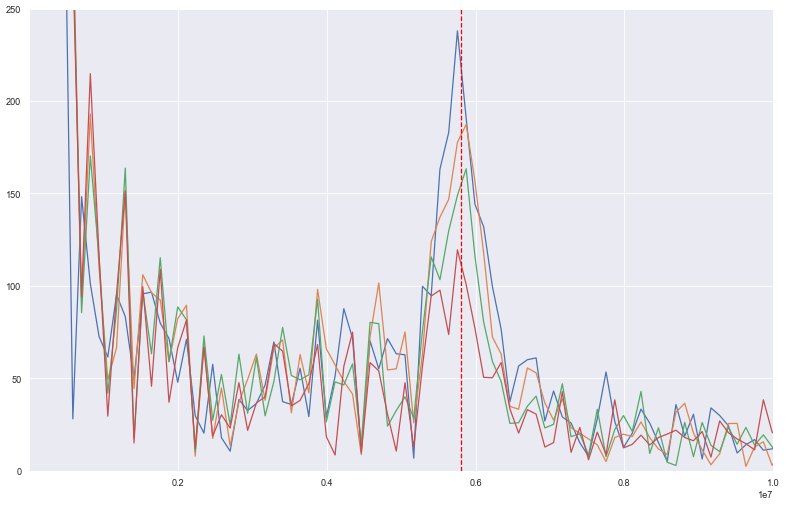

In [375]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k");

plt.plot(f_k, np.abs(S_sum[0][1:1065]))
plt.plot(f_k, np.abs(S_sum[1][1:1065]))
plt.plot(f_k, np.abs(S_sum[2][1:1065]))
plt.plot(f_k, np.abs(S_sum[3][1:1065]))
plt.axvline(x=5.8*10**6, ls='--', color='red')

plt.xlim([500, 10**7])
plt.ylim([0, 250])

None

In [376]:
i = np.arange(2128)

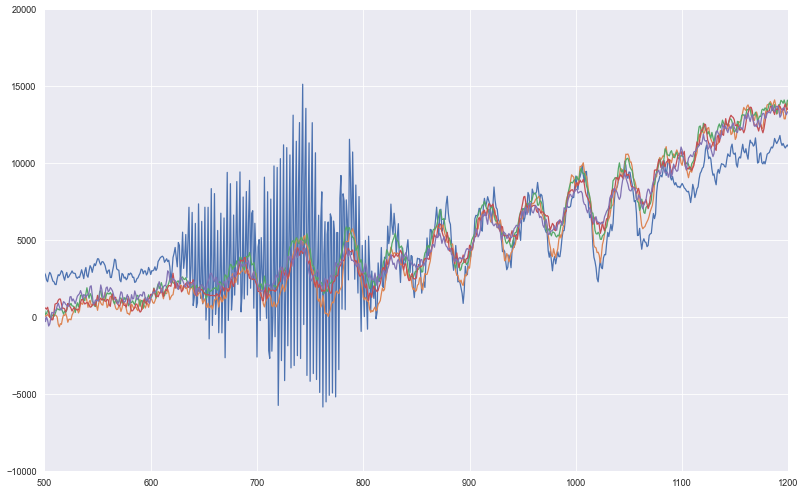

In [377]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(i, R[0])
plt.plot(i, R[1])
plt.plot(i, R[2])
plt.plot(i, R[3])
plt.plot(i, R[4])

plt.xlim([500, 1200])
plt.ylim([-1*10**4, 2*10**4])

None


## Data Averaging for tomography

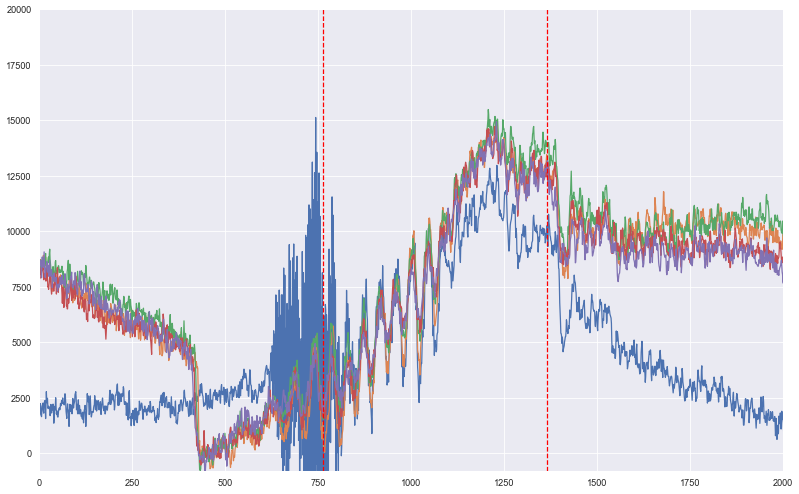

In [378]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(i, R[0])
plt.plot(i, R[1])
plt.plot(i, R[2])
plt.plot(i, R[3])
plt.plot(i, R[4])

plt.axvline(x=(2128 / 2 - 300), ls='--', color='red')
plt.axvline(x=(2128 / 2 + 300), ls='--', color='red')


plt.xlim([0, 2000])
plt.ylim([-800, 2*10**4])

None

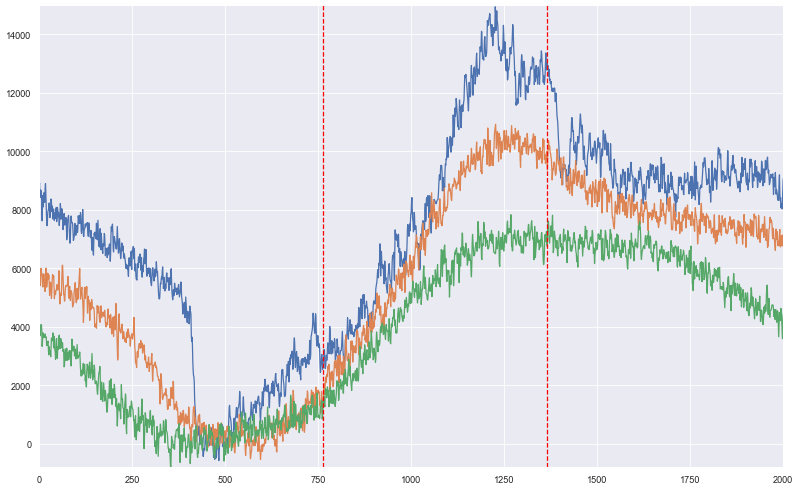

In [379]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(i, R[5])
plt.plot(i, R[60])
plt.plot(i, R[120])

plt.axvline(x=(2128 / 2 - 300), ls='--', color='red')
plt.axvline(x=(2128 / 2 + 300), ls='--', color='red')


plt.xlim([0, 2000])
plt.ylim([-800, 1.5*10**4])

None

In [380]:
i = np.arange(2128)
step = 10**6 * delta_T * i

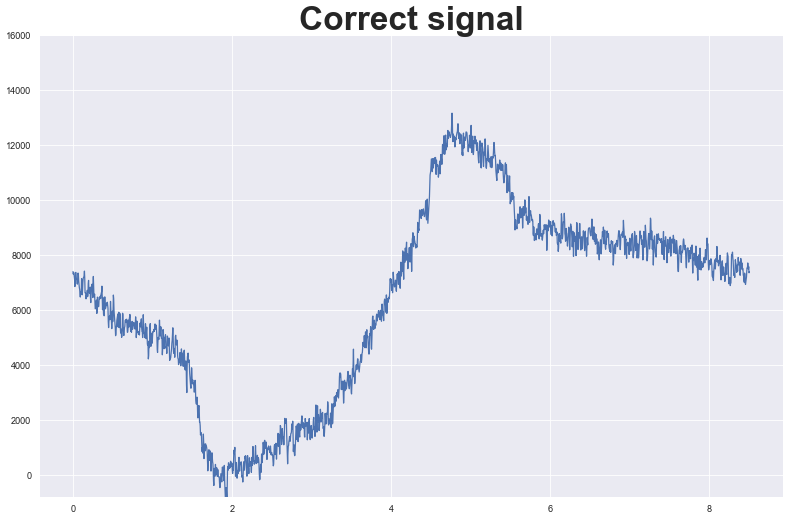

In [381]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(step, R[17])

plt.title('Correct signal', fontsize=40, fontweight='bold')

plt.ylim([-800, 1.6*10**4])

None

In [382]:
N_tum = N / period

N_ast = 7
N_at = 2
N_ap = 2

j_a = np.arange(np.floor((N_tum - N_ast) / (2 * N_at + 1))).astype(int)

L_p = np.floor(period / (2 * N_ap + 1))

i_a = np.arange(L_p).astype(int)

**эта штука написана верно, но косяк на 486 итерации, нужно проверять R. Именно с этого шага не те значения в векторох содержатся**

In [383]:
ro = np.zeros((len(i_a), len(j_a)))

for i in i_a:
    for j in j_a:
        sum_R = 0
        for n in range(-N_at, N_at+1):
            sum_R += np.sum(R[N_ast + (2 * N_at + 1) * j + n][N_ap + (2 * N_ap + 1) * i - 2: N_ap + (2 * N_ap + 1) * i + 2 + 1])
        
        sum_R /= (2 * N_at + 1) * (2 * N_ap + 1)
        ro[i, j] = sum_R

# ro = ro.T.reshape(-1, 1)

In [397]:
step = delta_T * (2 * N_ap + 1) * i_a

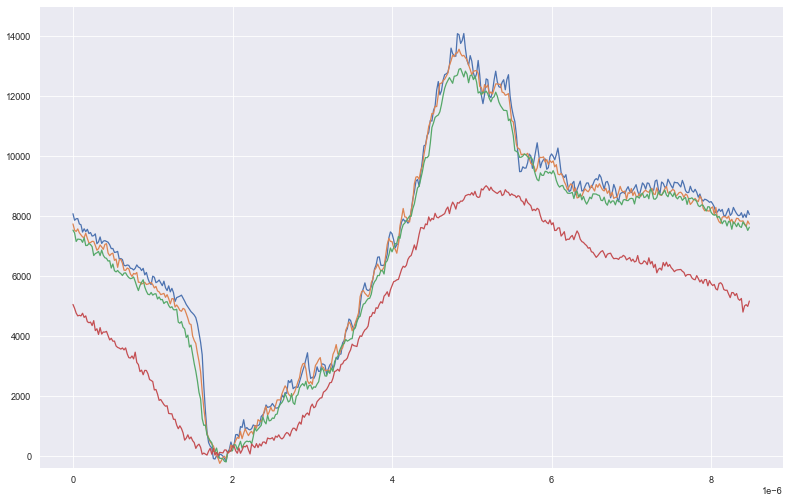

In [398]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(step, ro[i_a, 0])
plt.plot(step, ro[i_a, 1])
plt.plot(step, ro[i_a, 2])
plt.plot(step, ro[i_a, 15])


plt.ylim([-400, 1.5*10**4]);


## Computation of the distribution

In [476]:
N_p1 = 2
N_p2 = 10
N_p = 8
p_max = 4 * 10**(-3)

gamma = 1 + 3.2 / 938
alfa = 0.0476

eta = 1 / gamma**2 - alfa

n_p = np.arange(2 * N_p + 1)
m_p = np.arange(2 * N_p + 1)

In [477]:
N_t = (2 * N_at + 1) * (N_p2 - N_p1)

p_np = p_max * (n_p - N_p) / N_p

In [478]:
ro_0 = ro[i_a, N_p1] - 30

ro_fin_0 = ro[i_a, N_p2] #тут есть косяк, выбираются другие элементы

In [479]:
S1 = np.sum(ro_0)
S2 = np.sum(ro_fin_0)

In [480]:
ro_fin = ro_fin_0 + 0.1 * ((S1 - S2) / L_p)

np.sum(ro_fin) # не сходится  ## сходится, но из-за костыля

2365092.060479276

In [542]:
def shift_distr(ro, x, period):

    result_rt = []

    for iter in range(len(x)):
        S = fft(ro) / len(ro)

        for k in range(len(S) // 2 + 1):
        
            S[k] = S[k] * np.exp((2j * np.pi) / period * x[iter] * k)

        for k in range(1, len(S) // 2):
            S[len(S)-k] = S[len(S)-k] * np.exp(-(2j * np.pi) / period * x[iter] * k)

        rt = (ifft(S) * S.shape).real

        result_rt.append(rt)

    return result_rt


In [543]:
p_a = shift_distr(ro_0, eta * p_np * L_p * N_t, L_p) # работает верно

In [560]:
def get_distr(pf, N_iter): 

    A = np.zeros(2 * N_p + 1)

    for k in range(N_iter + 1):
        for n in range(2 * N_p + 1):
            
            delta_f = pf - np.sum([A[i] * p_a[i] for i in range(2 * N_p + 1)], axis=0)

            A[n] += np.sum(delta_f @ p_a[n]) / np.sum(p_a[n]**2)

            A[n] = 0 if A[n] < 0 else A[n]
    
    return A


In [561]:
A2 = get_distr(ro_fin, 800) # работает верно

In [562]:
ro_fit_2 = np.sum([A2[i] * p_a[i] for i in range(2 * N_p + 1)], axis=0)

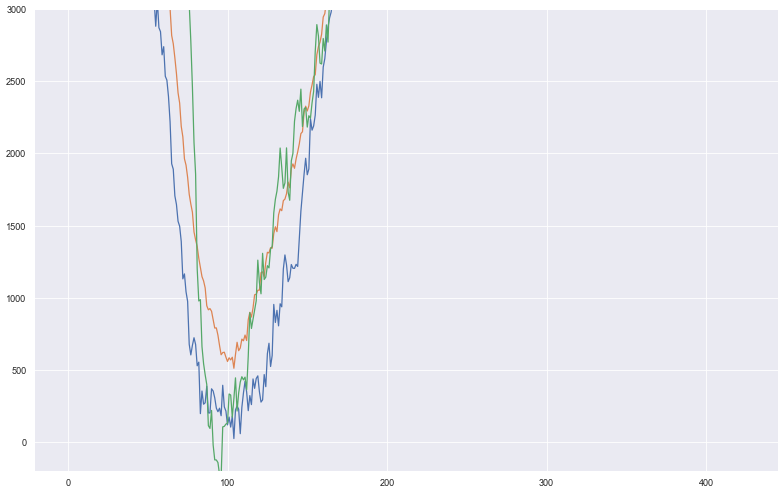

In [575]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(np.arange(L_p), ro_fin)
plt.plot(np.arange(L_p), ro_fit_2)
plt.plot(np.arange(L_p), ro_0)

plt.ylim([-200, 3*10**3])

None

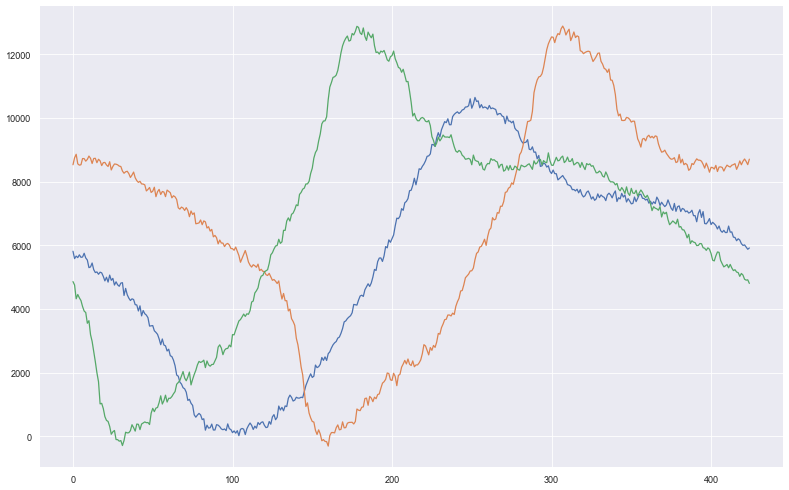

In [571]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(np.arange(L_p), ro_fin)
plt.plot(np.arange(L_p), p_a[0])
plt.plot(np.arange(L_p), p_a[2*N_p])

None

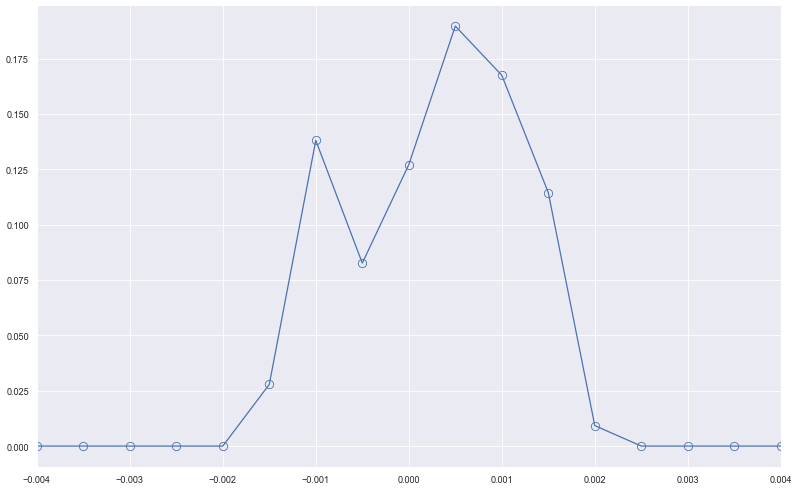

In [583]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(p_np, A2, marker="o", markerfacecolor='none', markersize=10)

plt.xlim([-p_max, p_max])

None

In [584]:
step = 10**6 * (2 * N_ap + 1) * delta_T * np.arange(L_p)

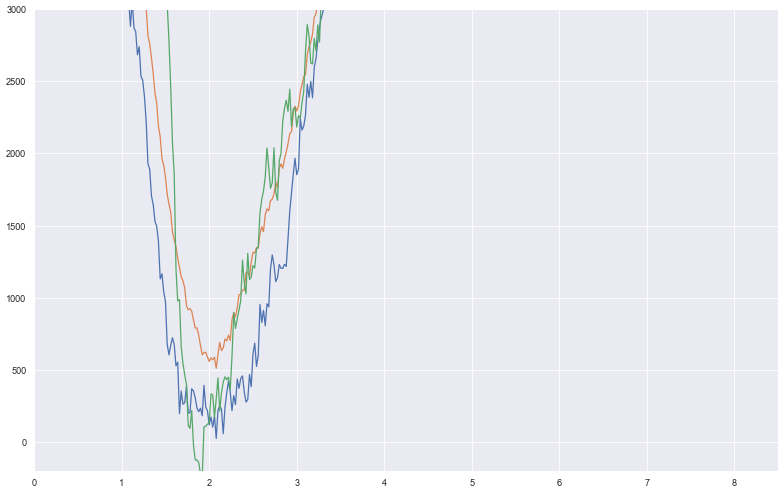

In [587]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(step, ro_fin)
plt.plot(step, ro_fit_2)
plt.plot(step, ro_0)

plt.ylim([-200, 3*10**3])
plt.xlim([0, 10**6 * (2 * N_ap + 1) * delta_T * L_p])


None


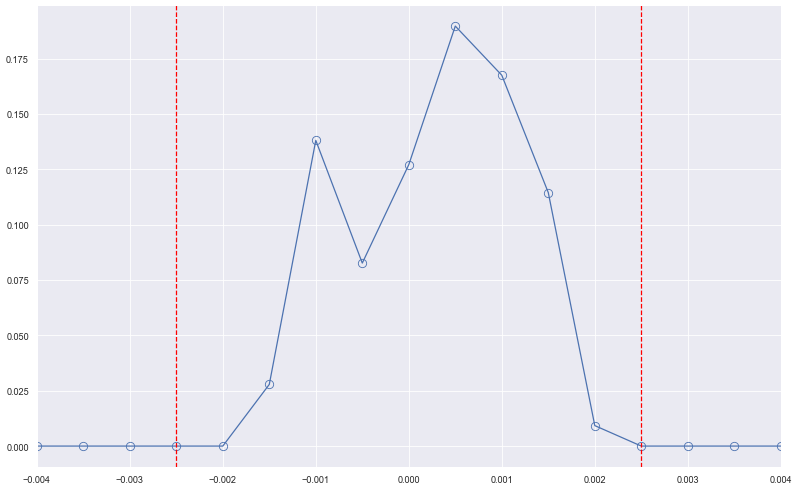

In [588]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(p_np, A2, marker="o", markerfacecolor='none', markersize=10)

plt.axvline(x=-2.5 * 10**(-3), ls='--', color='red')
plt.axvline(x=2.5 * 10**(-3), ls='--', color='red')

plt.xlim([-p_max, p_max])

None

## Decay of betatron motion with rectungular momentum distribution 

In [825]:
N_p = 40
delta_Q = 0.02
i_p = np.arange(N_p+1)
jj = np.arange(len(S_xx))

In [846]:
B_y = CorrectTune(y, v_y, N_p, delta_Q)

nb = np.array(range(B_y[1], B_y[3] + 1))

x_b = nb - 0.5 * (B_y[1] + B_y[3])
A_b = B_y[5] *  x_b ** 2 + B_y[6] * x_b + B_y[7] 

In [847]:
step = jj / NN

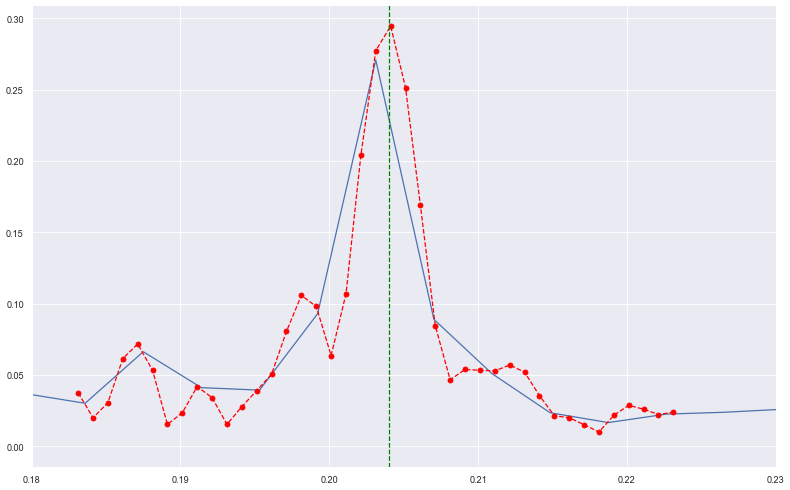

In [848]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(step, np.abs(S_yy))
plt.plot(B_y[8][i_p], np.abs(B_y[9]) / 250 , color='red', ls='--', marker='o')

plt.axvline(x=B_y[0], ls='--', color='green')

plt.xlim([0.18, 0.23])

None

In [849]:
step = x_b + (B_y[1] + B_y[3]) / 2

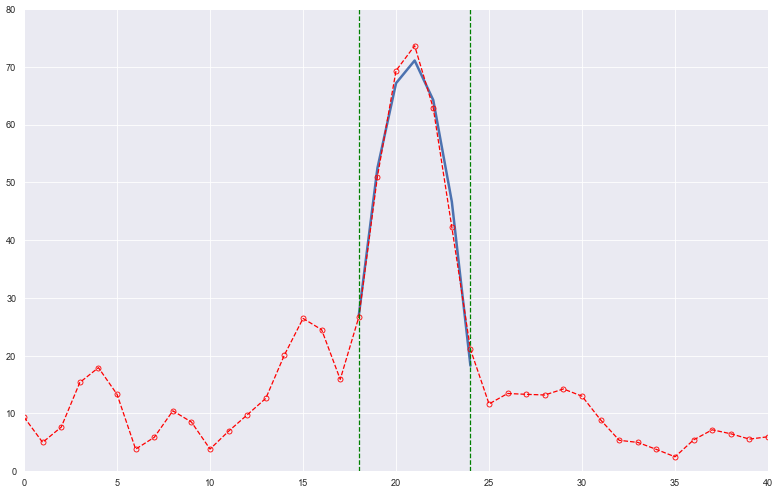

In [850]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(step, A_b, linewidth= 3)
plt.plot(i_p, np.abs(B_y[9]), color='red', ls='--', marker='o', markerfacecolor='none')

plt.axvline(x=B_y[1], ls='--', color='green')
plt.axvline(x=B_y[3], ls='--', color='green')

plt.xlim([0, 40])
plt.ylim([0, 80])

None

In [852]:
B_x = CorrectTune(x, v_x, N_p, delta_Q)

nb = np.array(range(B_x[1], B_x[3] + 1))

x_b = nb - 0.5 * (B_x[1] + B_x[3])
A_b = B_x[5] *  x_b ** 2 + B_x[6] * x_b + B_x[7] 

In [853]:
step = jj / NN

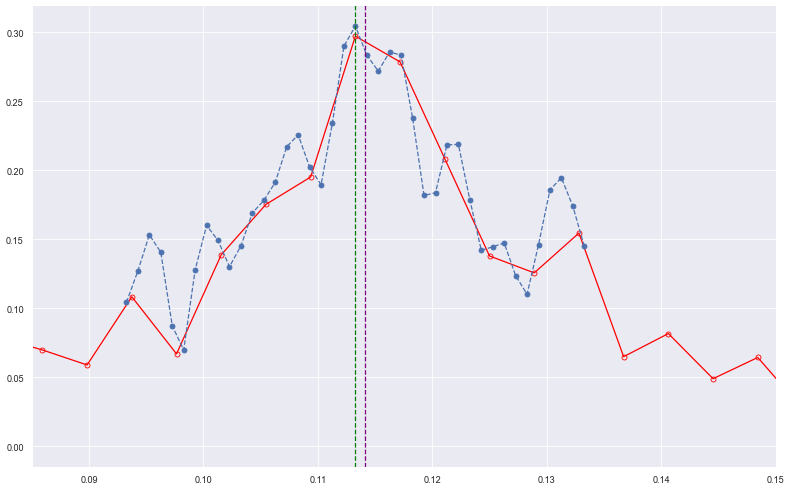

In [866]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(step, np.abs(S_xx), color='red', marker='o', markerfacecolor='none')
plt.plot(B_x[8][i_p], np.abs(B_x[9]) / 250, marker='o', ls='--')

plt.axvline(x=v_x, ls='--', color='green')
plt.axvline(x=B_x[0], ls='--', color='purple')

plt.xlim([0.085, 0.15])

None

In [868]:
step = x_b + (B_x[1] + B_x[3]) / 2

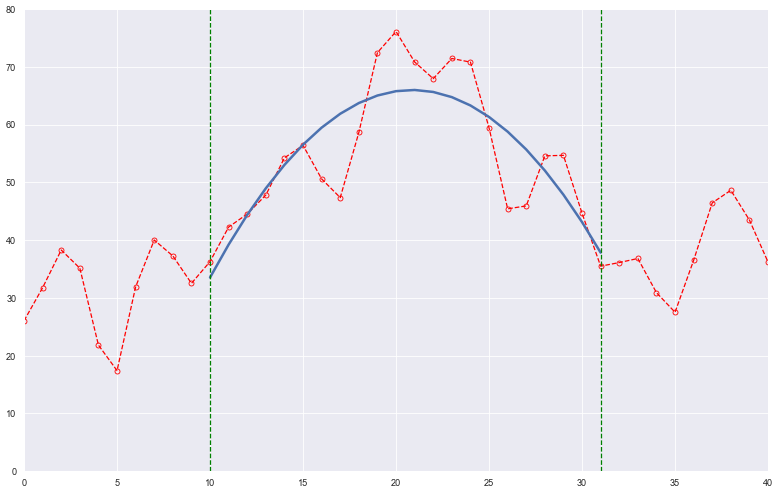

In [869]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(i_p, np.abs(B_x[9]), color='red', ls='--', marker='o', markerfacecolor='none')
plt.plot(step, A_b, linewidth= 3)

plt.axvline(x=B_x[1], ls='--', color='green')
plt.axvline(x=B_x[3], ls='--', color='green')

plt.xlim([0, 40])
plt.ylim([0, 80])

None